# Data

## Download data

In [1]:
import requests
import zipfile
from pathlib import Path
import os

In [2]:
data_path = Path("data")
downloaded_file_path = data_path / "food.zip"

if not data_path.is_dir():

  data_path.mkdir()

with open(downloaded_file_path, "wb") as f:
  request = requests.get("https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip")
  f.write(request.content)
  f.close

with zipfile.ZipFile(data_path / "food.zip") as zipref:
  zipref.extractall(data_path)

os.remove(downloaded_file_path)

In [3]:
# train and test directory
test_dir = data_path / "10_food_classes_all_data/test"
train_dir = data_path / "10_food_classes_all_data/train"
train_dir, test_dir

(PosixPath('data/10_food_classes_all_data/train'),
 PosixPath('data/10_food_classes_all_data/test'))

## Load the data and turn them into dataloader

In [4]:
import torch
import torchvision
from torchvision import transforms

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
IMG_SIZE = 224
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

train_data = torchvision.datasets.ImageFolder(root=train_dir,
                                              transform=transform)

test_data = torchvision.datasets.ImageFolder(root=test_dir,
                                             transform=transform)

class_names = train_data.classes

train_dataloader = torch.utils.data.DataLoader(dataset = train_data,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=NUM_WORKERS)

test_dataloader = torch.utils.data.DataLoader(dataset=test_data,
                                              batch_size=BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=NUM_WORKERS)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ec1d7a82530>,
 ['chicken_curry',
  'chicken_wings',
  'fried_rice',
  'grilled_salmon',
  'hamburger',
  'ice_cream',
  'pizza',
  'ramen',
  'steak',
  'sushi'])

## Visualize random image

In [7]:
import random
import matplotlib.pyplot as plt

In [8]:
image, label = next(iter(train_dataloader))
image.shape, label

(torch.Size([32, 3, 224, 224]),
 tensor([5, 5, 5, 7, 6, 9, 5, 4, 9, 9, 4, 5, 9, 5, 4, 7, 0, 0, 3, 3, 0, 0, 2, 9,
         3, 2, 8, 7, 1, 5, 4, 8]))

(-0.5, 223.5, 223.5, -0.5)

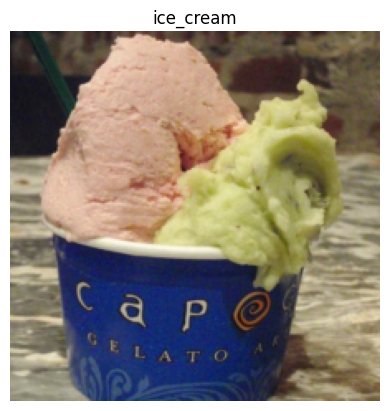

In [9]:
idx = random.randint(0, image.shape[0]-1)
plt.imshow(image[idx].permute(1, 2, 0))
plt.title(class_names[label[idx].item()])
plt.axis(False)

# Build Vision Transformer ViT

## Embedding block

In [10]:
import torch
from torch import nn

In [11]:
class EmbeddingBlock(nn.Module):
  def __init__(self,
               in_channels:int=3,
               embedding_dim:int=768,
               patch_size:int=16,
               IMG_SIZE=224,
               dropout:float=0.1):
    super().__init__()

    self.patcher = nn.Conv2d(in_channels=in_channels,
                            out_channels=embedding_dim,
                            kernel_size=patch_size,
                            stride=patch_size,
                            padding=0)

    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    num_patches = int(IMG_SIZE**2 / patch_size**2)

    self.position_embed = nn.Parameter(torch.randn(size=(1, num_patches+1, embedding_dim)),
                                       requires_grad=True)
    self.class_token = nn.Parameter(torch.randn(size=(1, 1, embedding_dim)),
                                    requires_grad=True)

    self.dropout = nn.Dropout(p=dropout)

  def forward(self, x):
    batch_size = x.shape[0]
    x = self.patcher(x)
    x = self.flatten(x).permute(0, 2, 1)
    class_token = self.class_token.expand(batch_size, -1, -1)
    x = torch.cat((class_token, x), dim=1)
    x = x + self.position_embed
    return self.dropout(x)



In [12]:
embed_block = EmbeddingBlock()
embeds = embed_block(image)
embeds.shape

torch.Size([32, 197, 768])

## Transformer Encoder Block

In [13]:
class TransformerEncoder(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               num_heads:int=12,
               att_dropout:float=0,
               mlp_dropout:float=0.1):
    super().__init__()
    self.atten_layer = nn.MultiheadAttention(embed_dim=embedding_dim,
                                             num_heads=num_heads,
                                             dropout=att_dropout,
                                             batch_first=True)

    self.norm_layer_att = nn.LayerNorm(normalized_shape=embedding_dim)
    self.norm_layer_mlp = nn.LayerNorm(normalized_shape=embedding_dim)

    self.mlp_layer = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=mlp_dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.GELU(),
        nn.Dropout(p=mlp_dropout)
    )



  def forward(self, x):
    norm_att = self.norm_layer_att(x)
    att_out, _ = self.atten_layer(query=norm_att,
                                  value=norm_att,
                                  key=norm_att,
                                  need_weights=False)
    residual_att = att_out + x

    norm_mlp = self.norm_layer_mlp(residual_att)
    mlp_out = self.mlp_layer(norm_mlp)
    residual_mlp = mlp_out + residual_att

    return residual_mlp




In [14]:
transformer_encoder = TransformerEncoder()
trans_out = transformer_encoder(embeds)
trans_out.shape

torch.Size([32, 197, 768])

## ViT Class

In [15]:
class ViT(nn.Module):
  def __init__(self,
               IMG_SIZE:int=224,
               in_channels:int=3,
               embedding_dim:int=768,
               patch_size:int=16,
               num_heads:int=12,
               mlp_size:int=3074,
               num_tansformer_layer:int=12,
               num_classes:int=1000,
               embed_dropout:float=0.1,
               att_dropout:float=0,
               mlp_dropout:float=0.1):
    super().__init__()

    self.embedding = EmbeddingBlock(in_channels=in_channels,
                                    embedding_dim=embedding_dim,
                                    patch_size=patch_size,
                                    IMG_SIZE=IMG_SIZE,
                                    dropout=embed_dropout)

    self.transformer_encoder = nn.Sequential(*[TransformerEncoder(embedding_dim=embedding_dim,
                                                  mlp_size=mlp_size,
                                                  num_heads=num_heads,
                                                  att_dropout=att_dropout,
                                                  mlp_dropout=mlp_dropout) for _ in range(num_tansformer_layer)]) 

    self.classifier = nn.Linear(in_features=embedding_dim,
                                out_features=num_classes)


  def forward(self, x):
    x = self.embedding(x)
    x = self.transformer_encoder(x)
    x = self.classifier(x[:, 0])

    return x

In [16]:
vit = ViT(IMG_SIZE=224,
          in_channels=3,
          embedding_dim=768,
          patch_size=16,
          num_heads=12,
          mlp_size=3074,
          num_classes=len(class_names)).to(device)
output = vit(image.to(device))

In [17]:
output.shape

torch.Size([32, 10])

In [18]:
from torchinfo import summary
summary(model=vit,
       input_size=(32, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                          [32, 3, 224, 224]    [32, 10]             --                   True
├─EmbeddingBlock (embedding)                       [32, 3, 224, 224]    [32, 197, 768]       152,064              True
│    └─Conv2d (patcher)                            [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                           [32, 768, 14, 14]    [32, 768, 196]       --                   --
│    └─Dropout (dropout)                           [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                 [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoder (0)                      [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─LayerNorm (norm_layer_att)         

# Train the ViT Model

## loss and optimizer

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit.parameters(),
                                lr=0.001)

## Train and test loop

In [20]:
def train_step(model,
               train_dataloader,
               loss_fn,
               optimizer,
               device=device):

  model.train()
  losses = 0.0
  accs = 0.0
  for X, y in train_dataloader:
    X, y = X.to(device), y.to(device)
    y_logits = model(X)
    loss = loss_fn(y_logits, y)
    losses += loss.item()

    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
    accs += (y == y_preds).sum().item() / len(y_preds)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  losses /= len(train_dataloader)
  accs /= len(train_dataloader)

  return losses, accs

def test_step(model,
              test_dataloader,
              loss_fn,
              device=device):
  model.eval()
  losses, accs = 0.0, 0.0

  with torch.inference_mode():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)

      y_logits = model(X)
      losses += loss_fn(y_logits, y).item()

      y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
      accs += (y == y_pred).sum().item()/ len(y_pred)


    losses /= len(test_dataloader)
    accs /= len(test_dataloader)

  return losses, accs


## Train the model

In [21]:
from tqdm.auto import tqdm

In [22]:
EPOCHS = 10

vit_results = {"train_loss":[],
              "train_acc":[],
              "test_loss":[],
              "test_acc":[]}
for epoch in tqdm(range(EPOCHS)):
  train_loss, train_acc = train_step(model=vit,
                                     train_dataloader=train_dataloader,
                                     loss_fn=loss_fn,
                                     optimizer=optimizer,
                                     device=device)

  test_loss, test_acc = test_step(model=vit,
                                  test_dataloader=test_dataloader,
                                  loss_fn=loss_fn,
                                  device=device)
  vit_results["train_loss"].append(train_loss)
  vit_results["train_acc"].append(train_acc)
  vit_results["test_loss"].append(test_loss)
  vit_results["test_acc"].append(test_acc)

  print(f"epoch {epoch} | loss:{train_loss:.4f}, acc:{train_acc*100:.2f}% | val_loss:{test_loss:.4f}, val_acc:{test_acc*100:.2f}%")

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 0 | loss:5.6401, acc:12.86% | val_loss:2.5752, val_acc:17.72%
epoch 1 | loss:2.2724, acc:20.04% | val_loss:2.2345, val_acc:22.19%
epoch 2 | loss:2.1850, acc:22.53% | val_loss:2.0794, val_acc:25.08%


KeyboardInterrupt: 

## Plot loss curves

In [23]:
#    https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

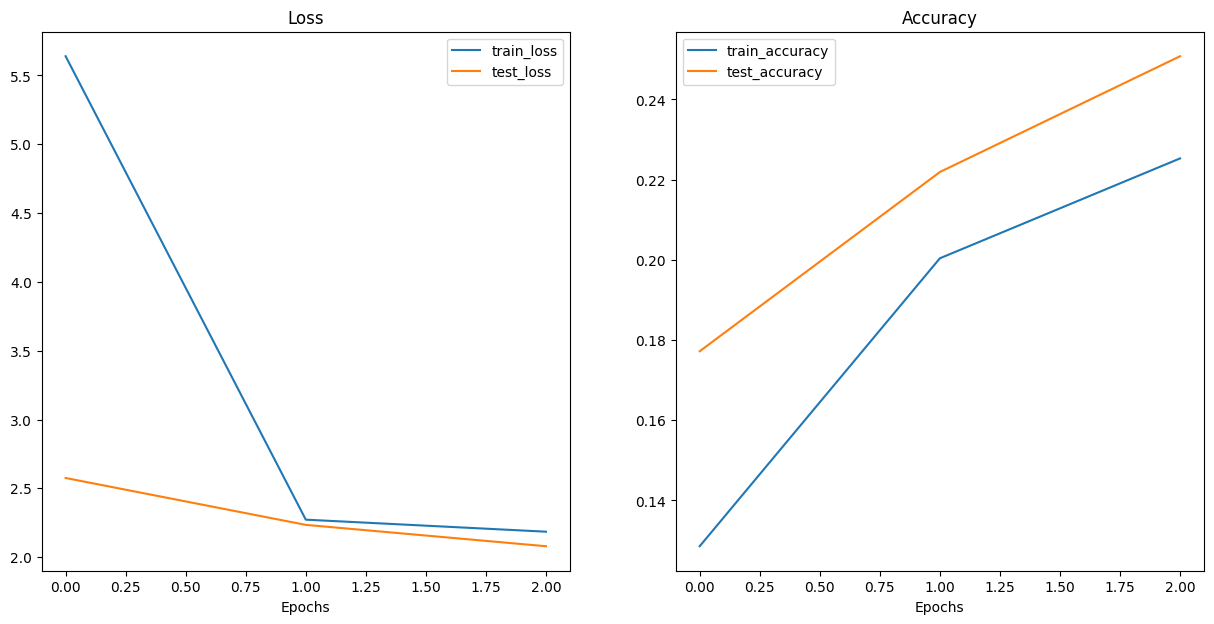

In [25]:
plot_loss_curves(vit_results)

## Using Pretrained ViT (feature extractor)

In [26]:
import torch
import torchvision
from torchinfo import summary

### Prepare the data

In [54]:
weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_transform = weights.transforms()

train_data_pre_vit = torchvision.datasets.ImageFolder(root=train_dir,
                                                     transform=vit_transform)

test_data_pre_vit = torchvision.datasets.ImageFolder(root=test_dir,
                                                    transform=vit_transform)

train_dataloader_pre_vit = torch.utils.data.DataLoader(dataset=train_data_pre_vit,
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=True,
                                                      num_workers=NUM_WORKERS)

test_dataloader_pre_vit = torch.utils.data.DataLoader(dataset=test_data_pre_vit,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=False,
                                                     num_workers=NUM_WORKERS)

### Loading the pretrained ViT, freeze all weights and change the classifier

In [34]:
pretrained_vit = torchvision.models.vit_b_16(weights=weights).to(device)
for param in pretrained_vit.parameters():
    param.requires_grad = False

pretrained_vit.heads = nn.Linear(in_features=768,
                                out_features=len(class_names))

summary(model=pretrained_vit,
       input_size=(1, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 10]              768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### pretrained_vit loss and optimizer

In [36]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_vit.parameters(),
                            lr=0.001)

### Train the pretrained_vit

In [74]:
EPOCHS = 3

pretrained_vit_results = {"train_loss":[],
              "train_acc":[],
              "test_loss":[],
              "test_acc":[]}
for epoch in tqdm(range(EPOCHS)):
  train_loss, train_acc = train_step(model=pretrained_vit,
                                     train_dataloader=train_dataloader_pre_vit,
                                     loss_fn=loss_fn,
                                     optimizer=optimizer,
                                     device=device)

  test_loss, test_acc = test_step(model=pretrained_vit,
                                  test_dataloader=test_dataloader_pre_vit,
                                  loss_fn=loss_fn,
                                  device=device)
  pretrained_vit_results["train_loss"].append(train_loss)
  pretrained_vit_results["train_acc"].append(train_acc)
  pretrained_vit_results["test_loss"].append(test_loss)
  pretrained_vit_results["test_acc"].append(test_acc)

  print(f"epoch {epoch} | loss:{train_loss:.4f}, acc:{train_acc*100:.2f}% | val_loss:{test_loss:.4f}, val_acc:{test_acc*100:.2f}%")

  0%|          | 0/3 [00:00<?, ?it/s]

epoch 0 | loss:0.2511, acc:92.34% | val_loss:0.2301, val_acc:92.44%
epoch 1 | loss:0.2253, acc:93.44% | val_loss:0.2219, val_acc:92.72%
epoch 2 | loss:0.2036, acc:94.22% | val_loss:0.2141, val_acc:93.00%


### plot loss curves of the pretrained vit

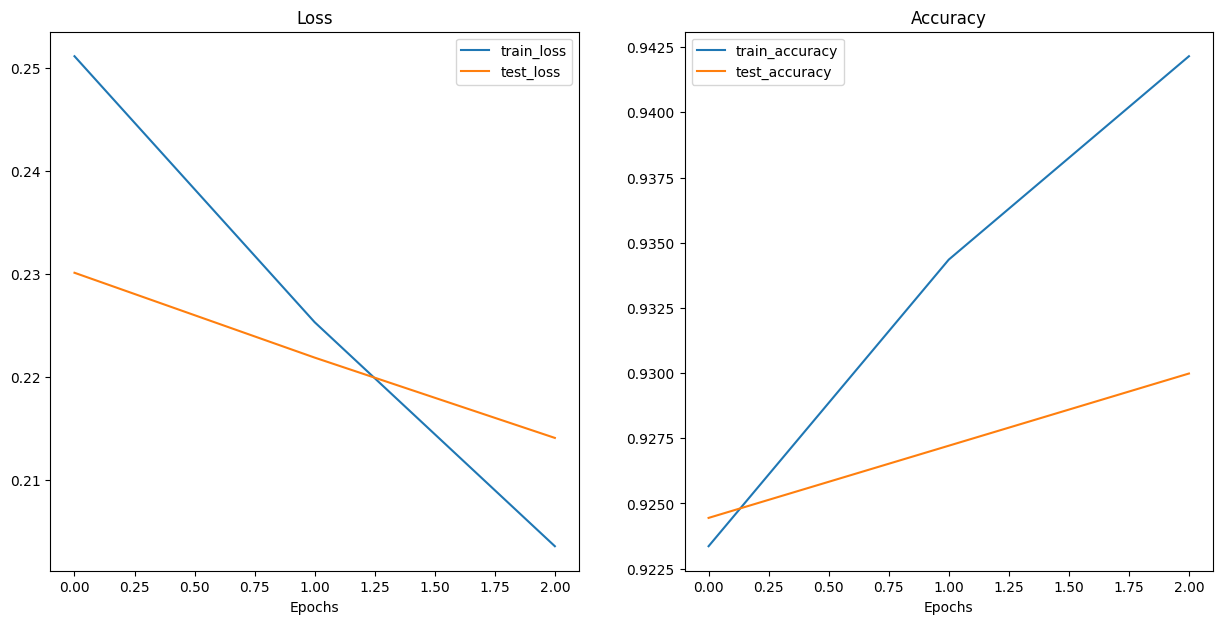

In [75]:
plot_loss_curves(pretrained_vit_results)

### Downlaod an image and test pretrained vit

In [49]:
from PIL import Image
import numpy as np

In [42]:
with open("image.jpg", "wb") as f:
    request = requests.get("https://www.allrecipes.com/thmb/SI6dn__pfJb9G5eBpYAqkyGCLxQ=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/50050-five-minute-ice-cream-DDMFS-4x3-076-fbf49ca6248e4dceb3f43a4f02823dd9.jpg")
    f.write(request.content)

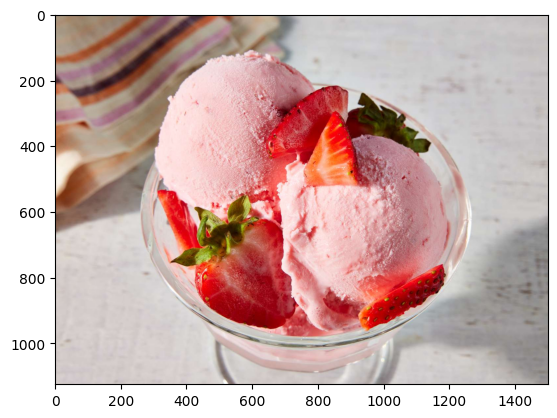

In [60]:
image = Image.open("image.jpg")
plt.imshow(image)


(-0.5, 1499.5, 1124.5, -0.5)

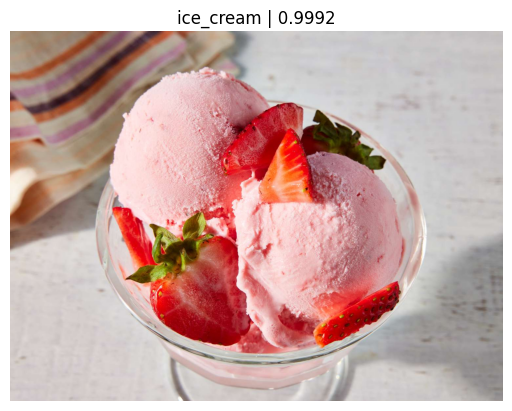

In [73]:
trans_image = vit_transform(image).to(device)

pretrained_vit.eval()
with torch.inference_mode():
    y_logit = pretrained_vit(trans_image.unsqueeze(dim=0))
y_prob = torch.softmax(y_logit,dim=1).max().item()
y_pred = torch.softmax(y_logit, dim=1).argmax().item()

plt.imshow(image)
plt.title(f"{class_names[y_pred]} | {y_prob:.4f}")
plt.axis(False)